In [5]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
import json
import holidays
pd.set_option('display.max_rows', 60)
pd.set_option('display.max_columns', 60)

In [4]:
trips25 = pd.read_csv(r'.\OneDrive_2025-10-14\Data hackathon 2025 Fall_PTC data\open_data_trips_2018-2025\open_data_trips_2025.csv')
trips24 = pd.read_csv(r'.\OneDrive_2025-10-14\Data hackathon 2025 Fall_PTC data\open_data_trips_2018-2025\open_data_trips_2024.csv')
trips = pd.concat([trips24, trips25], ignore_index=True)
trips["pickup_hr"] = pd.to_datetime(trips["pickup_hr"], errors="coerce", utc=True)
trips["pickup_hr"] = trips["pickup_hr"].dt.tz_convert("America/Toronto")
trips.head(5)

,ds,pickup_hr,pickup_municipality,pickup_community_council,pickup_ward,dropoff_municipality,dropoff_community_council,dropoff_ward,trip_ct,avg_fare,avg_trip_distance,avg_waittime
0,2024-01-02,2024-01-02 00:00:00-05:00,Toronto,Toronto and East York,10 - Spadina-Fort York,Toronto,Toronto and East York,10 - Spadina-Fort York,95,11.52,2.36,3.86
1,2024-01-02,2024-01-02 00:00:00-05:00,Toronto,Toronto and East York,10 - Spadina-Fort York,Toronto,Toronto and East York,13 - Toronto Centre,64,12.53,3.57,3.59
2,2024-01-02,2024-01-02 00:00:00-05:00,Pearson Airport,Not in Toronto,Not in Toronto,Toronto,Toronto and East York,10 - Spadina-Fort York,56,54.35,27.98,10.68
3,2024-01-02,2024-01-02 00:00:00-05:00,Toronto,Toronto and East York,10 - Spadina-Fort York,Toronto,Toronto and East York,11 - University-Rosedale,44,13.36,3.67,3.07
4,2024-01-02,2024-01-02 00:00:00-05:00,Toronto,Toronto and East York,13 - Toronto Centre,Toronto,Toronto and East York,13 - Toronto Centre,44,9.27,1.79,3.09


In [6]:
# Adding holidays
ontario_holidays = holidays.country_holidays('CA', subdiv='ON')

trips['is_holiday'] = trips['ds'].apply(lambda x: 1 if x in ontario_holidays else 0)
trips['is_holiday'].value_counts()

is_holiday
0    5023719
1     108869
Name: count, dtype: int64

From-airport params (beta0, beta_d): (15.597650831845254, 1.025194464436098)
To-airport params   (beta0, beta_d): (13.79036373114343, 1.0228336315875872)


C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_16504\1784921249.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: wmean(g["multiplier_hat_smooth"], g["trip_ct"]))


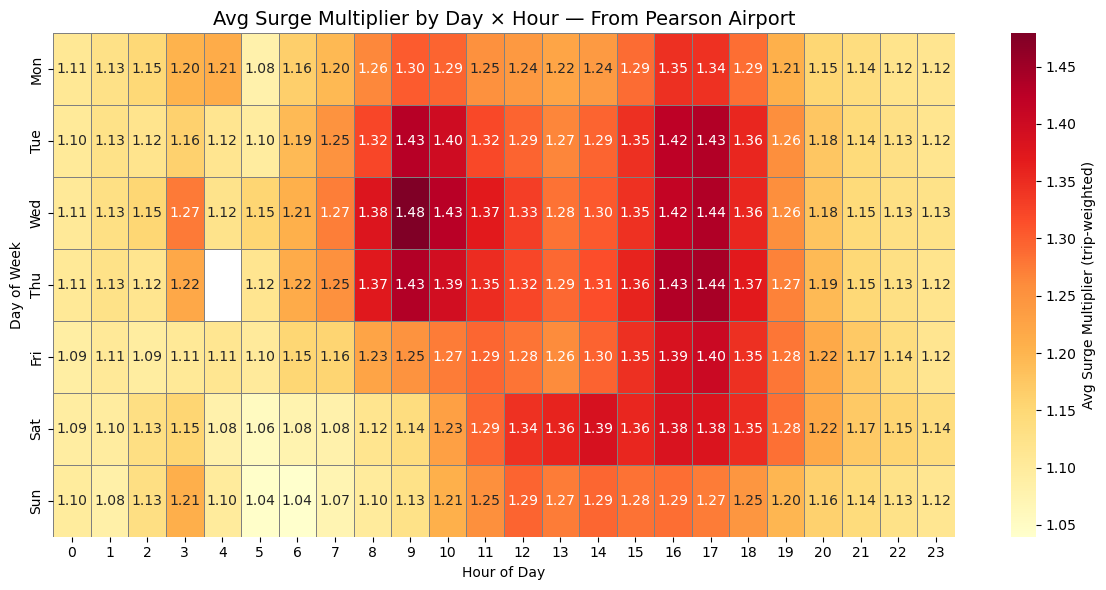

C:\Users\mwendwa.kiko\AppData\Local\Temp\ipykernel_16504\1784921249.py:124: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: wmean(g["multiplier_hat_smooth"], g["trip_ct"]))


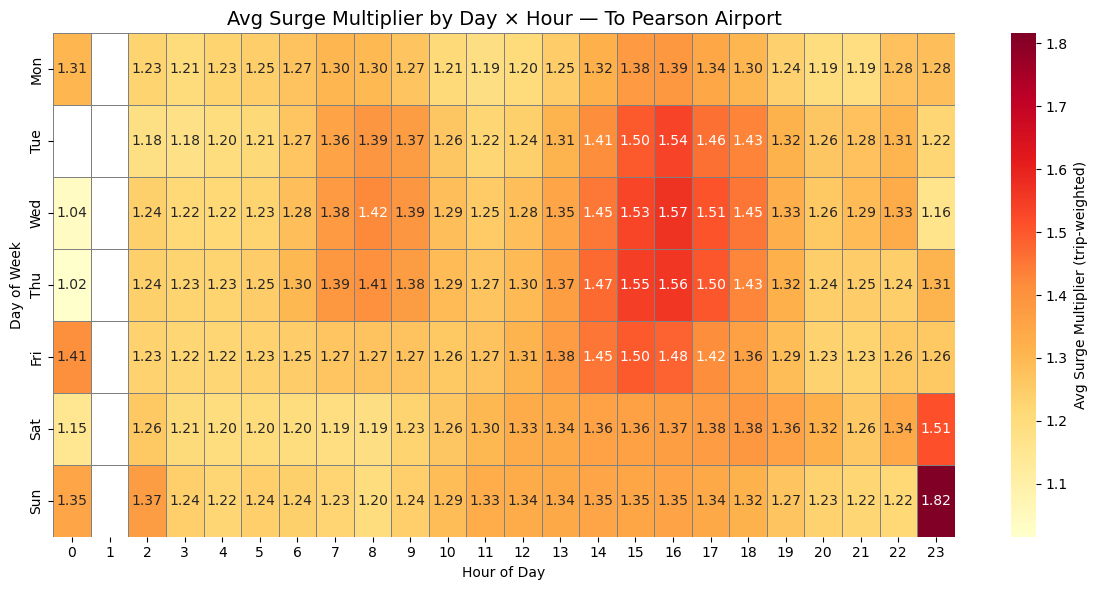

In [7]:
AIRPORT_NAME = "Pearson Airport"
trips["direction"] = np.where(
    trips["pickup_municipality"] == AIRPORT_NAME, "from_airport",
    np.where(trips["dropoff_municipality"] == AIRPORT_NAME, "to_airport", np.nan)
)
df0 = trips[trips["direction"].notna()].copy()

# Exclude trips outside toronto & airport
df0 = df0[
    (df0["pickup_ward"] != "Not included elsewhere") &
    (df0["dropoff_ward"] != "Not included elsewhere")
].copy()

# Use pickup_hr as pickup_ts directly (already localized) ---
df0["pickup_ts"] = df0["pickup_hr"]
df0 = df0[df0["pickup_ts"].notna()].copy()

# Drop fallback DST hour (1:00–1:59 AM on Nov 3, 2024) 
mask_fallback = (
    (df0["pickup_ts"].dt.date == pd.Timestamp("2024-11-03").date()) &
    (df0["pickup_ts"].dt.hour == 1)
)
df0 = df0[~mask_fallback].copy()

# Create 1 hour time slot
df0["slot_1h"] = df0["pickup_ts"].dt.floor("1h")

# Add Time features
df0["dow"] = df0["pickup_ts"].dt.dayofweek
df0["hour"] = df0["pickup_ts"].dt.hour
df0["hour_of_week"] = 24 * df0["dow"] + df0["hour"]

#  Zone ID creation (municipality + ward)
def make_zone(df, muni_col, ward_col):
    a = df[muni_col].astype(str).str.strip().fillna("")
    b = df[ward_col].astype(str).str.strip().fillna("")
    return np.where(a == "", b, np.where(b == "", a, a + "_" + b))

df0["o_zone"] = make_zone(df0, "pickup_municipality", "pickup_ward")
df0["d_zone"] = make_zone(df0, "dropoff_municipality", "dropoff_ward")

# Filter valid data
df0 = df0[
    np.isfinite(df0["avg_fare"]) &
    np.isfinite(df0["avg_trip_distance"]) &
    np.isfinite(df0["avg_waittime"])
]
df0 = df0[df0["avg_trip_distance"] >= 1.0]  # filter out trips that are too short (this step is not required)

# Weighted mean helper
def wmean(x, w):
    x = x.astype(float)
    w = w.astype(float)
    mask = (~x.isna()) & (~w.isna())
    return np.average(x[mask], weights=w[mask]) if mask.any() else np.nan

def compute_multipliers_per_direction(df_dir, offpeak_wait_q=0.4, offpeak_dem_q=0.5, smooth_bins=3):
    df = df_dir.copy()

    # Off-peak selection by origin zone
    df["wait_pct"] = df.groupby("o_zone")["avg_waittime"].transform(lambda s: s.rank(pct=True))
    df["dem_pct"]  = df.groupby("o_zone")["trip_ct"].transform(lambda s: s.rank(pct=True))
    offpeak = (df["wait_pct"] <= offpeak_wait_q) & (df["dem_pct"] <= offpeak_dem_q)  # wait time <= 40% of the wait time between OD pairs & # trip demand <= 50% of the trip demand between OD pairs
    df_off = df[offpeak].copy()

    # --- Regression features ---
    # Base: ONLY distance (drop wait time from regression)
    X_base = df_off[["avg_trip_distance"]].astype(float)
    # Fixed effects (origin, destination, hour-of-week)
    X_fe = pd.get_dummies(df_off[["o_zone", "d_zone", "hour_of_week"]], drop_first=True)
    X = pd.concat([X_base, X_fe], axis=1)
    y = df_off["avg_fare"].astype(float).values

    # Fit OLS
    reg = LinearRegression().fit(X, y)
    beta0 = float(reg.intercept_)
    beta_d = float(reg.coef_[X.columns.get_loc("avg_trip_distance")])

    # --- Construct surge multiplier ---
    # Denominator uses ONLY the distance rate now
    den = beta_d * df["avg_trip_distance"].values
    den = np.clip(den, 1e-6, None)

    m_hat = (df["avg_fare"].values - beta0) / den
    df["multiplier_hat"] = np.clip(m_hat, 0.5, 6.0)  # bouding surge estimate so it can’t go crazy values

    # Sort and smooth over 1-hour slots  (compute a centered rolling mean over the time slots to smooth the multiplier value)
    df = df.sort_values(["o_zone", "d_zone", "slot_1h"])    
    df["multiplier_hat_smooth"] = (
        df.groupby(["o_zone", "d_zone"])["multiplier_hat"]
          .apply(lambda s: s.rolling(smooth_bins, min_periods=1, center=True).mean())
          .values
    )

    # Coefficients
    df["beta0_base_fee"] = beta0
    df["beta_d_km_rate"] = beta_d

    return df[[
        "slot_1h", "pickup_ts", "direction",
        "o_zone", "d_zone",
        "trip_ct", "avg_fare", "avg_trip_distance", "avg_waittime",
        "beta0_base_fee", "beta_d_km_rate",
        "multiplier_hat", "multiplier_hat_smooth"
    ]].copy(), (beta0, beta_d)

# Run for to/from directions and combine
from_result, from_params = compute_multipliers_per_direction(df0[df0["direction"] == "from_airport"])
to_result,   to_params   = compute_multipliers_per_direction(df0[df0["direction"] == "to_airport"])
both_result = pd.concat([from_result, to_result], ignore_index=True)

print("From-airport params (beta0, beta_d):", from_params)
print("To-airport params   (beta0, beta_d):", to_params)

# Heatmap plotting (trip-weighted by hour-of-week)
def plot_day_hour_heatmap(res, title_suffix):
    plot_df = res.copy()
    plot_df["dow"] = plot_df["pickup_ts"].dt.dayofweek
    plot_df["hour"] = plot_df["pickup_ts"].dt.hour

    pivot = (
        plot_df[["dow", "hour", "multiplier_hat_smooth", "trip_ct"]]
        .groupby(["dow", "hour"])
        .apply(lambda g: wmean(g["multiplier_hat_smooth"], g["trip_ct"]))
        .unstack()
        .reindex(index=range(7), columns=range(24))
    )

    pivot.index = ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"]

    plt.figure(figsize=(12, 6))
    sns.heatmap(
        pivot, cmap="YlOrRd", annot=True, fmt=".2f",
        linewidths=0.4, linecolor="gray",
        cbar_kws={"label": "Avg Surge Multiplier (trip-weighted)"}
    )
    plt.title(f"Avg Surge Multiplier by Day × Hour — {title_suffix}", fontsize=14)
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.tight_layout()
    plt.show()

# Plot to/from airport multiplier results
plot_day_hour_heatmap(from_result, "From Pearson Airport")
plot_day_hour_heatmap(to_result,   "To Pearson Airport")